<a href="https://colab.research.google.com/github/kirath2205/Machine-Learning-Plant-seedling/blob/main/inception_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [37]:
def define_model(width, height):
    model_input = tf.keras.layers.Input(shape=(width, height, 3), name='image_input')
    model_main = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet')(model_input)
    model_dense1 = tf.keras.layers.Flatten()(model_main)
    model_dense2 = tf.keras.layers.Dense(128, activation='relu')(model_dense1)
    model_out = tf.keras.layers.Dense(12, activation="softmax")(model_dense2)

    model = tf.keras.models.Model(model_input,  model_out)
    optimizer = tf.keras.optimizers.Adam(lr=0.00004, beta_1=0.9, beta_2=0.999)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


In [38]:
def training_callbacks():
    
    # save best model regularly
    save_best_model =  tf.keras.callbacks.ModelCheckpoint('best_model_inception_resnet_plant_seedlings_attempt_1', monitor='val_accuracy', verbose=1, save_best_only=True)
    
    # reduce learning rate when it stops decreasing
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.6,
                              patience = 3, min_lr = 1e-7, verbose = 1, cooldown = 1)
    
    # stop training early if no further improvement
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'loss', min_delta = 1e-2, patience = 15, verbose = 1,
        mode = 'min', baseline = None, restore_best_weights = True
    )

    return [save_best_model, reduce_lr, early_stopping]

In [39]:
def define_generators():
  height = 299
  width = 299
  batch_size = 16
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=360,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.5,
        vertical_flip=True,
        horizontal_flip=True,
        validation_split=0.1, # change to use validation instead of training on entire training set
    )

  train_generator = train_datagen.flow_from_directory(
        directory='Documents/train',
        target_size=(width, height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode="categorical",
        subset='training',
    )

  validation_generator = train_datagen.flow_from_directory(
        directory='Documents/train',
        target_size=(width, height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode="categorical",
        subset='validation',
    )

  test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

  test_generator = test_datagen.flow_from_directory(
        directory='Documents/',
        classes=['test'],
        target_size=(width, height),
        batch_size=1,
        color_mode='rgb',
        shuffle=False,
        class_mode='categorical')

  return train_generator, validation_generator, test_generator


In [42]:
height = 299
width = 299
num_epochs = 100
batch_size = 24

In [43]:
model = define_model(width, height)
train_gen, validation_gen, test_gen = define_generators()

# the actual training
history = model.fit(
    train_gen,
    callbacks = training_callbacks(),
    epochs = num_epochs,
    steps_per_epoch = train_gen.samples // batch_size,
    validation_data = validation_gen,
    validation_steps = validation_gen.samples // batch_size,
)

Found 4279 images belonging to 12 classes.
Found 471 images belonging to 12 classes.
Found 794 images belonging to 1 classes.
Epoch 1/100
178/178 [==============================] - ETA: 0s - loss: 1.8945 - accuracy: 0.3669
Epoch 00001: val_accuracy improved from -inf to 0.65789, saving model to best_model_inception_resnet_plant_seedlings_attempt_1
INFO:tensorflow:Assets written to: best_model_inception_resnet_plant_seedlings_attempt_1/assets
178/178 [==============================] - 118s 664ms/step - loss: 1.8945 - accuracy: 0.3669 - val_loss: 1.0977 - val_accuracy: 0.6579 - lr: 4.0000e-05
Epoch 2/100
178/178 [==============================] - ETA: 0s - loss: 0.7406 - accuracy: 0.7520
Epoch 00002: val_accuracy improved from 0.65789 to 0.84868, saving model to best_model_inception_resnet_plant_seedlings_attempt_1
INFO:tensorflow:Assets written to: best_model_inception_resnet_plant_seedlings_attempt_1/assets
178/178 [==============================] - 121s 678ms/step - loss: 0.7406 - acc

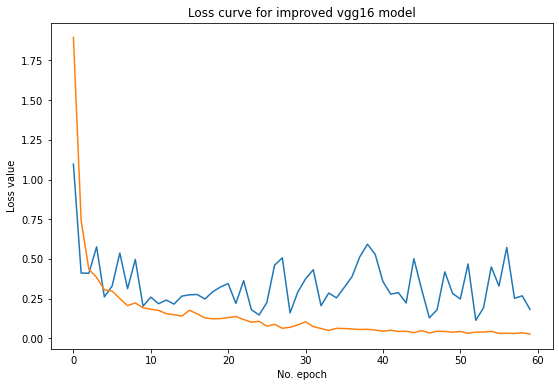

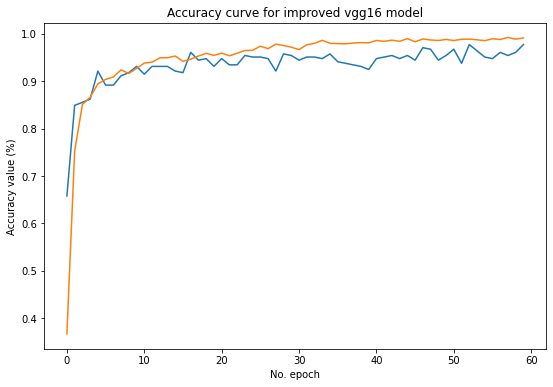

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize = (9,6))
plt.plot(history.history['val_loss'],label='Test loss')
plt.plot(history.history['loss'],label='Train loss')
plt.title('Loss curve for improved vgg16 model')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.figure(figsize = (9,6))
plt.plot(history.history['val_accuracy'],label = 'Test accuracy')
plt.plot(history.history['accuracy'],label = 'Train accuracy')
plt.title('Accuracy curve for improved vgg16 model')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [47]:
model = tf.keras.models.load_model('best_model_inception_resnet_plant_seedlings_attempt_1')
print(len(test_gen))
seedlings_types = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]
predictions = model.predict(test_gen, steps=test_gen.samples)

#predictions = model.predict(test_generator, steps=test_generator.samples)

class_list = []

for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  class_list += [seedlings_types[y_class]]

submission = pd.DataFrame()
submission['file'] = test_gen.filenames
submission['file'] = submission['file'].str.replace(r'test/', '')
submission['species'] = class_list

submission.to_csv('inception_resnet_submission_attempt_1.csv', index=False)

794
